# Sea Ice Advance and Retreat

Using the daily NSIDC sea ice extent product, figure out the day in each year when sea ice is present in each pixel to calculate day of sea ice advance and retreat, and the duration between thw two

In [1]:
#directory paths
_work_dir='/g/data/jk72/as2285/miz/'
_data_dir='/g/data/jk72/MIZ/'

In [2]:
#useful py libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
import sys
sys.path.append(_work_dir)

from utils.sea_ice_duration import sea_ice_duration

%run {_work_dir}utils/plot_tools.ipynb

In [4]:
%matplotlib inline

In [5]:
#some constants
CLIMAT_DATES=[1981,2010]
EAST_ANT_LONS=[71,160] #longitudes for east Antartica (easterly)
YEAR=2021


# Open the dataset

For this, we are going to treat historical and near real-time data as equivalent.

In [6]:
#lists of both the historical and near real-time files
daily_files = ! ls -d {_data_dir}NSIDC/G02202_V4/seaice_conc_daily*.nc {_data_dir}NSIDC/G10016_V2/daily/*.nc

In [7]:
#open it all
cdr_daily_ds=xr.open_mfdataset(
    daily_files, combine='nested',concat_dim='tdim', data_vars='minimal',
).swap_dims(
    {'tdim':'time', 'x':'xgrid','y':'ygrid'}
).rename(
    {'xgrid':'x','ygrid':'y'}
)  

In [8]:
cdr_daily_ds

<xarray.Dataset>
Dimensions:                      (time: 15972, y: 332, x: 316)
Coordinates:
  * time                         (time) datetime64[ns] 1978-10-25 ... 2022-07-17
  * x                            (x) float32 -3.938e+06 -3.912e+06 ... 3.938e+06
  * y                            (y) float32 4.338e+06 4.312e+06 ... -3.938e+06
Data variables:
    cdr_seaice_conc              (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    nsidc_bt_seaice_conc         (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    nsidc_nt_seaice_conc         (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    projection                   |S1 b''
    qa_of_cdr_seaice_conc        (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    spatial_interpolation_flag   (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    stdev_of_cdr_seaice_conc     (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    temporal_interpolation_flag  (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    latitude                     (y, x) float32 dask.array<chunksize=(332, 316), meta=np.ndarray>
    longitude                    (y, x) float32 dask.array<chunksize=(332, 316), meta=np.ndarray>
Attributes: (12/39)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc
    ...                        ...
    acknowledgment:            This project was supported in part by a grant ...
    platform:                  NIMBUS-7
    sensor:                    SMMR > Scanning Multichannel Microwave Radiometer
    date_created:              2021-06-21T21:22:35Z
    time_coverage_start:       1978-10-25T00:00:00Z
    time_coverage_end:         1978-12-31T23:59:59Z

# Calculate advance day / retreat day and season

For year of the groups defined (stating/ending Feb 15), find the day when advance and retreat starts:

In [9]:
cdr_duration=sea_ice_duration(cdr_daily_ds.cdr_seaice_conc)

In [10]:
cdr_duration.calc_duration()

In [11]:
adv_day_ds=cdr_duration.adv_day_ds
ret_day_ds=cdr_duration.ret_day_ds
duration_da=cdr_duration.duration_da

In [12]:
cdr_duration.calc_climat()

In [13]:
cdr_duration.calc_anoms()

# Plots for sanity - compare concentrations to dates identified as advance date

No Ice example:

/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.9/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


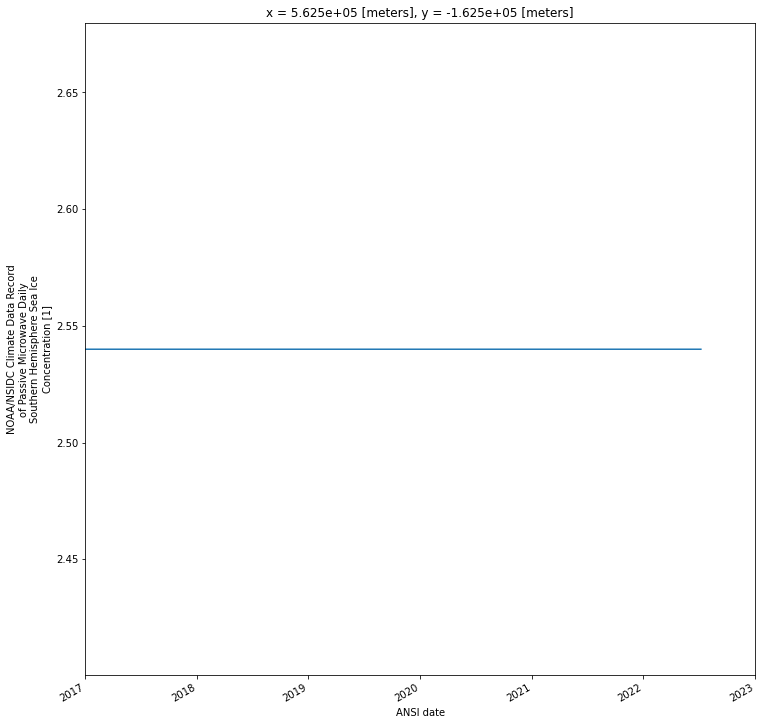

In [14]:
plt.figure(figsize=(12,12))
cdr_daily_ds.cdr_seaice_conc.isel(x=180,y=180).plot(xlim=[np.datetime64('2017'),np.datetime64('2023')])

plt.vlines(adv_day_ds.time.isel(x=180,y=180).values,0,1, color='red')

plt.vlines(ret_day_ds.time.isel(x=180,y=180).values,0,1, color='red')


Ice example

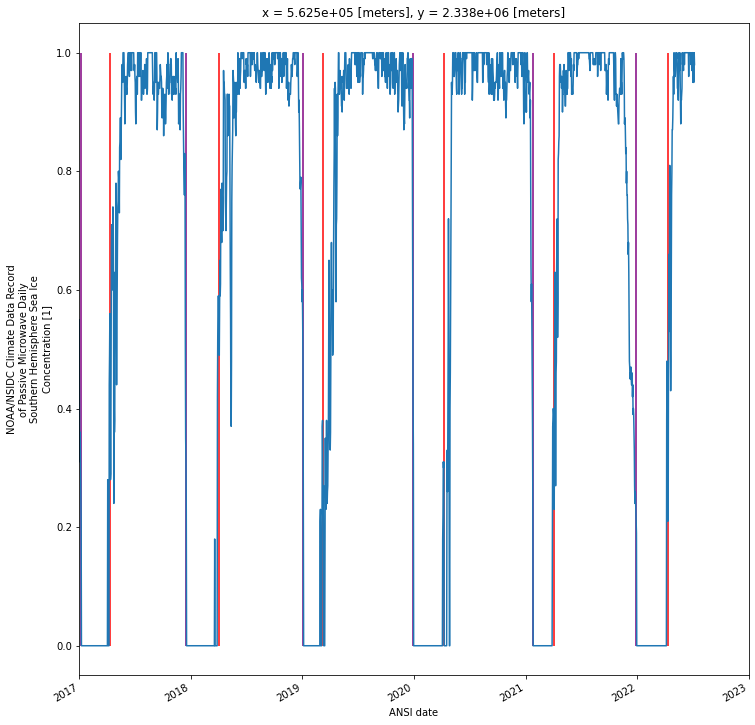

In [15]:
plt.figure(figsize=(12,12))
cdr_daily_ds.cdr_seaice_conc.isel(x=180,y=80).plot(xlim=[np.datetime64('2017'),np.datetime64('2023')])

plt.vlines(adv_day_ds.time.isel(x=180,y=80).values,0,1, color='red')

plt.vlines(ret_day_ds.time.isel(x=180,y=80).values,0,1, color='purple')


# Plots of sea ice advance / retreat / duration for a year

The functions here are written to provide the advance and retreat days in two ways.
1. a np.datetime object
2. the number of days since sea ice minima (Feb-16)

Check they look the same:

Text(0.5, 1.0, 'Index + 46 days - Sea Ice Advance 2021')

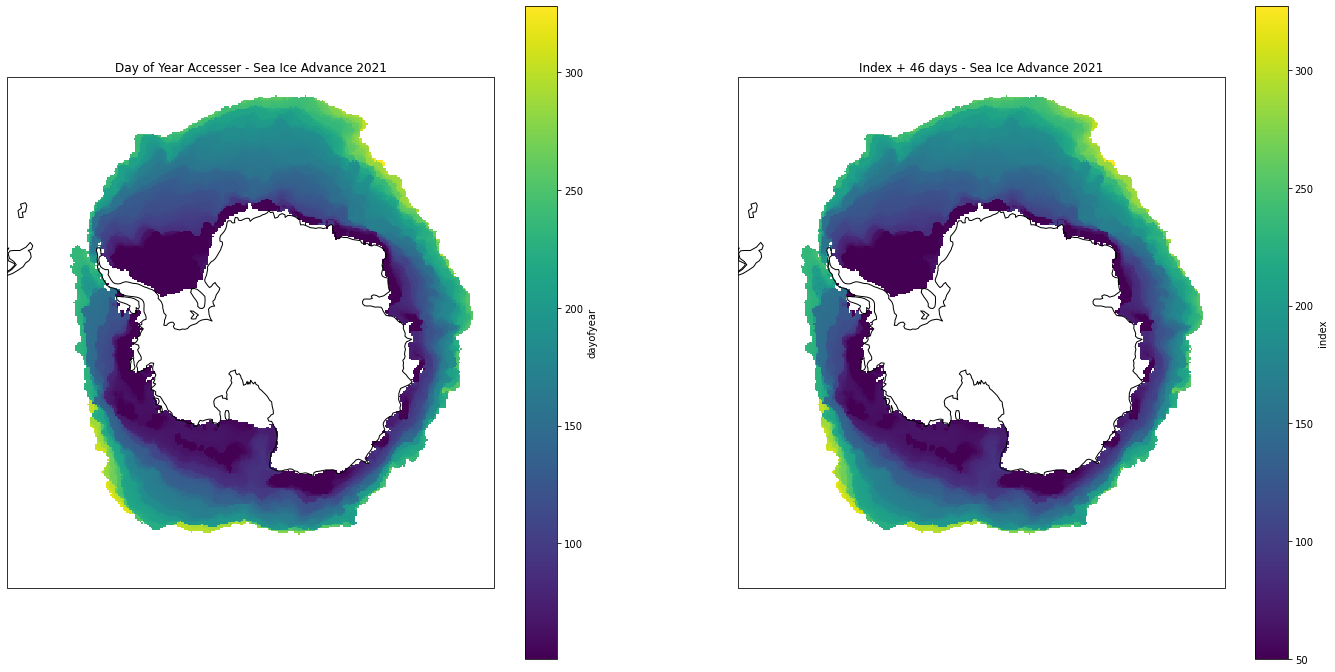

In [14]:
plt.figure(figsize=(24,12))
ax=plt.subplot(1,2,1,projection=ccrs.SouthPolarStereo())

adv_day_ds.time.sel(year=YEAR).dt.dayofyear.plot.pcolormesh(
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70)
)

ax.coastlines()
plt.title('Day of Year Accesser - Sea Ice Advance ' + str(YEAR) )

ax=plt.subplot(1,2,2,projection=ccrs.SouthPolarStereo())

(adv_day_ds.sel(year=YEAR).index+46).plot.pcolormesh(
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70)
)

ax.coastlines()
plt.title('Index + 46 days - Sea Ice Advance ' + str(YEAR))

#check the two plots are the same :)

Text(0.5, 1.0, 'Index + 46 Days - Sea Ice Retreat 2021')

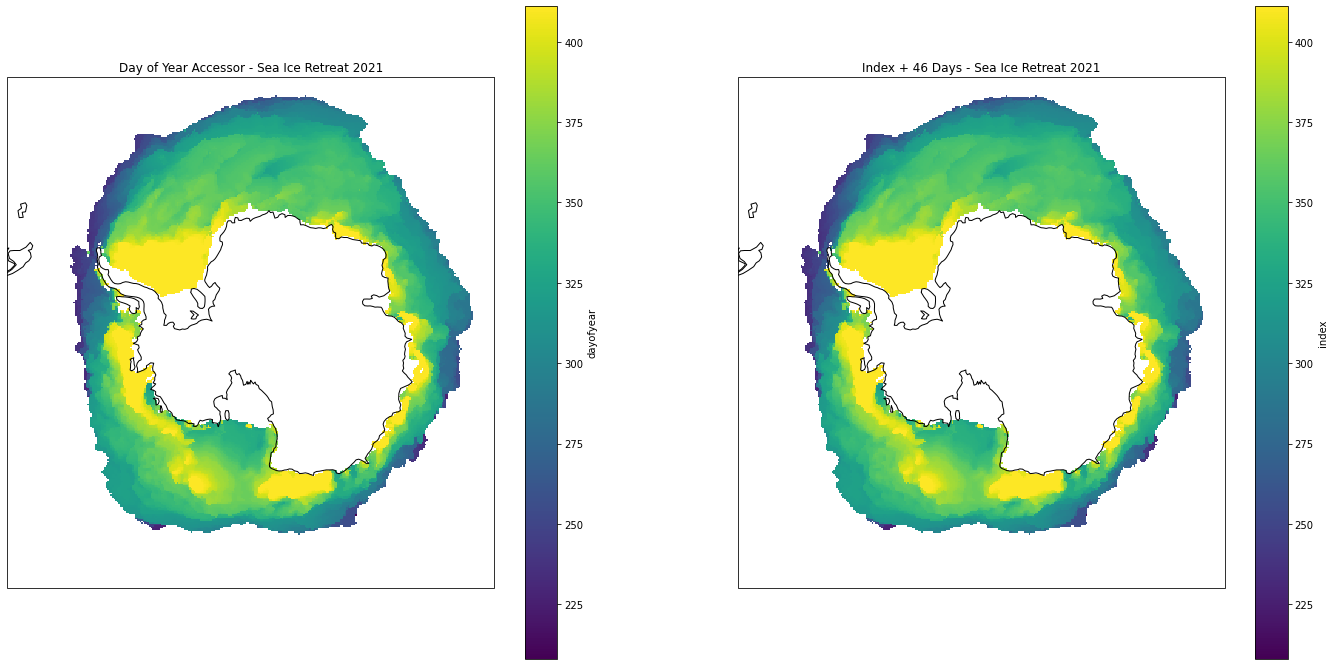

In [15]:
plt.figure(figsize=(24,12))
ax=plt.subplot(1,2,1,projection=ccrs.SouthPolarStereo())

#Corrections for over the year break
ret_dayofyear_da=ret_day_ds.time.dt.dayofyear
ret_dayofyear_da=ret_dayofyear_da.where(ret_dayofyear_da>46,other=(ret_dayofyear_da+365))


ret_dayofyear_da.sel(year=YEAR).plot.pcolormesh(
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70)
)

ax.coastlines()
plt.title('Day of Year Accessor - Sea Ice Retreat ' + str(YEAR))


ax=plt.subplot(1,2,2,projection=ccrs.SouthPolarStereo())

(ret_day_ds.sel(year=YEAR).index+46).plot.pcolormesh(
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70)
)

ax.coastlines()
plt.title('Index + 46 Days - Sea Ice Retreat ' + str(YEAR))

Just a random example to show the durations calculated look sensible

Text(0.5, 1.0, 'Sea Ice Duration 2021')

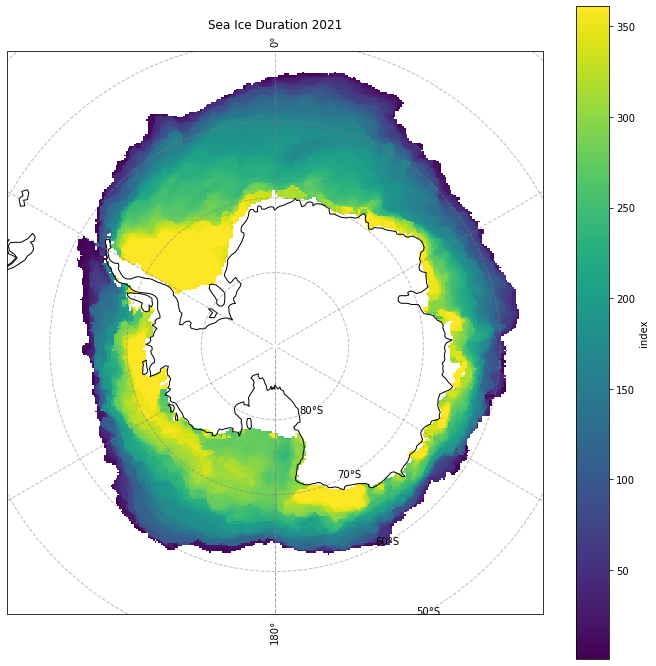

In [16]:
plt.figure(figsize=(12,12))
ax=plt.subplot(projection=ccrs.SouthPolarStereo(true_scale_latitude=-70))



duration_da.sel(year=YEAR).plot.pcolormesh(transform=ccrs.SouthPolarStereo(true_scale_latitude=-70))

ax.coastlines()

gl = ax.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
    #xlocs=[80,120,160], ylocs=[-60,-90]
)

plt.title('Sea Ice Duration ' + str(YEAR))

# Climatologies

/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


Text(0.5, 1.0, 'Sea Ice Advance Mean')

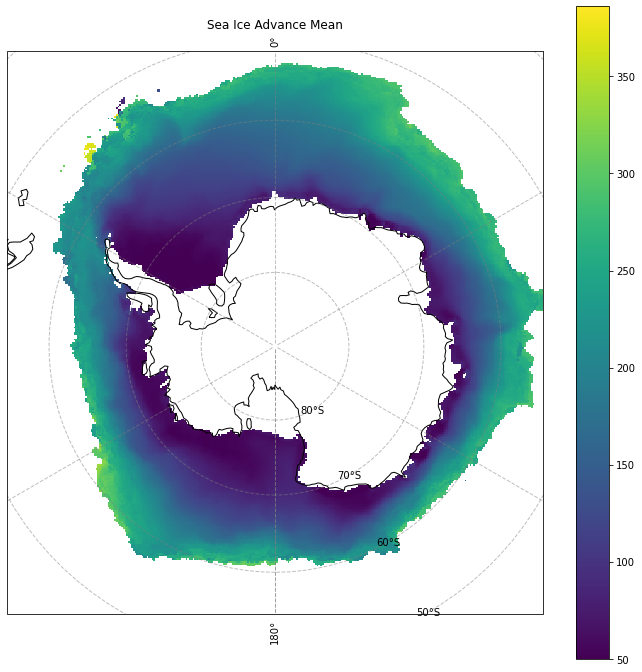

In [17]:
plt.figure(figsize=(12,12))
ax=plt.subplot(projection=ccrs.SouthPolarStereo())

plt.pcolormesh(
    cdr_duration.adv_climat_ds.x,
    cdr_duration.adv_climat_ds.y,
    cdr_duration.adv_climat_ds.ave+46,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
)

gl = ax.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
    #xlocs=[80,120,160], ylocs=[-60,-90]
)

ax.coastlines()
plt.colorbar()
plt.title('Sea Ice Advance Mean')

/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


Text(0.5, 1.0, 'Sea Ice Retreat')

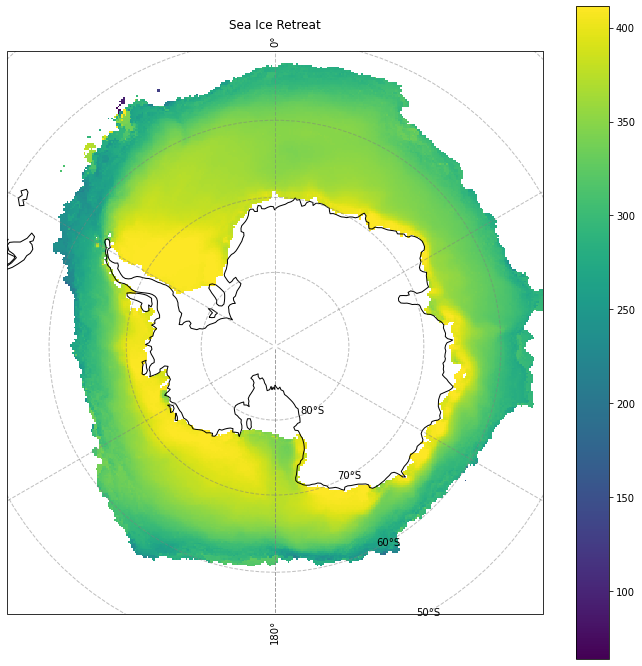

In [18]:
plt.figure(figsize=(12,12))
ax=plt.subplot(projection=ccrs.SouthPolarStereo())

plt.pcolormesh(
    cdr_duration.ret_climat_ds.x,
    cdr_duration.ret_climat_ds.y,
    cdr_duration.ret_climat_ds.ave+46,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
)

gl = ax.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
    #xlocs=[80,120,160], ylocs=[-60,-90]
)

ax.coastlines()
plt.colorbar()
plt.title('Sea Ice Retreat')

/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


Text(0.5, 1.0, 'Sea Ice Duration')

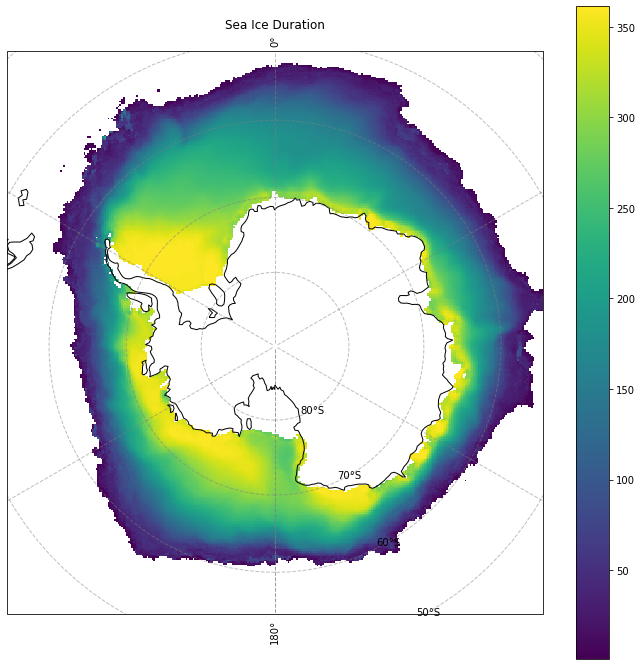

In [19]:
plt.figure(figsize=(12,12))
ax=plt.subplot(projection=ccrs.SouthPolarStereo())

plt.pcolormesh(
    cdr_duration.dur_climat_ds.x,
    cdr_duration.dur_climat_ds.y,
    cdr_duration.dur_climat_ds.ave,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
)

gl = ax.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
    #xlocs=[80,120,160], ylocs=[-60,-90]
)

ax.coastlines()
plt.colorbar()
plt.title('Sea Ice Duration')

As above, climatology of sea ice duration, but drawn to matched Massom et al. 2013

Text(0.5, 1.0, 'Sea Ice Advance Mean')

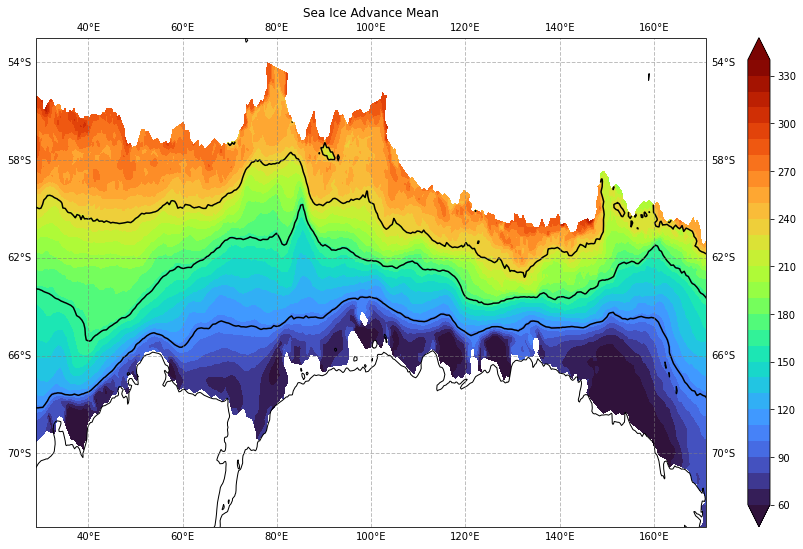

In [20]:
to_plot=cdr_duration.adv_climat_ds

plt.figure(figsize=(15,9))
ax=plt.subplot(
    projection=ccrs.PlateCarree(),
    xlim=(29,171),
    ylim=(-73,-53)
)

ax.set_aspect('auto')

plt.contourf(
    to_plot.x,
    to_plot.y,
    to_plot.ave+46,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
    levels=np.arange(60,341,10),
    cmap='turbo',
    extend='both'
)

plt.colorbar()

plt.contour(
    to_plot.x,
    to_plot.y,
    to_plot.ave+46,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
    levels=[(np.datetime64(f'{YEAR}-{iMonth:02.0f}-16')-(np.datetime64(f'{YEAR}-01-01'))+1).astype(int) for iMonth in [4,6,8]],
    colors='Black',
)

gl = ax.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
    xlocs=[40,60,80,100,120,140,160], ylocs=[-54,-58,-62,-66,-70]
)


ax.coastlines()
plt.title('Sea Ice Advance Mean')

Text(0.5, 1.0, 'Sea Ice Retreat Mean')

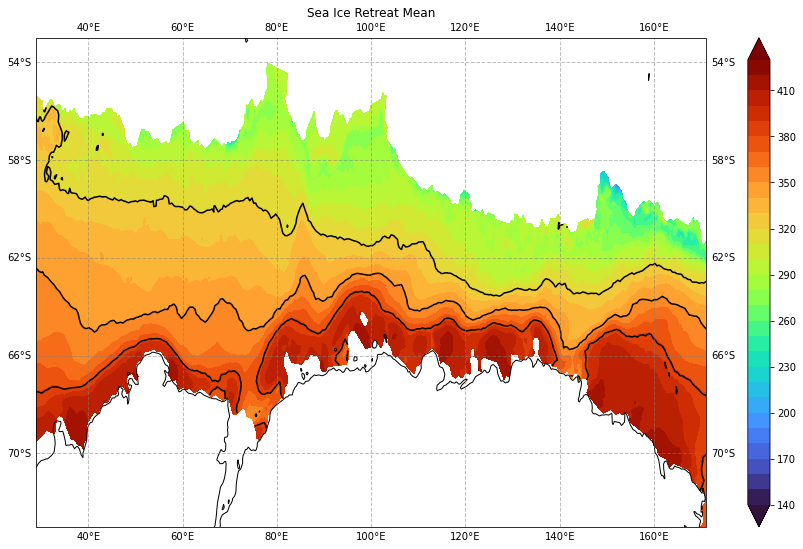

In [21]:
to_plot=cdr_duration.ret_climat_ds

plt.figure(figsize=(15,9))
ax=plt.subplot(
    projection=ccrs.PlateCarree(),
    xlim=(29,171),
    ylim=(-73,-53)
)

ax.set_aspect('auto')

plt.contourf(
    to_plot.x,
    to_plot.y,
    to_plot.ave+46,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
    levels=np.arange(140,431,10),
    cmap='turbo',
    extend='both'
)

plt.colorbar()

plt.contour(
    to_plot.x,
    to_plot.y,
    to_plot.ave+46,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
    levels=[*[(np.datetime64(f'{YEAR}-{iMonth:02.0f}-16')-(np.datetime64(f'{YEAR}-01-01'))+1).astype(int) for iMonth in [11,12]],
            (np.datetime64(f'{YEAR+1}-01-16')-(np.datetime64(f'{YEAR}-01-01'))+1).astype(int)],
    colors='Black',
)

gl = ax.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
    xlocs=[40,60,80,100,120,140,160], ylocs=[-54,-58,-62,-66,-70]
)


ax.coastlines()
plt.title('Sea Ice Retreat Mean')

Text(0.5, 1.0, 'Sea Ice Duration Mean')

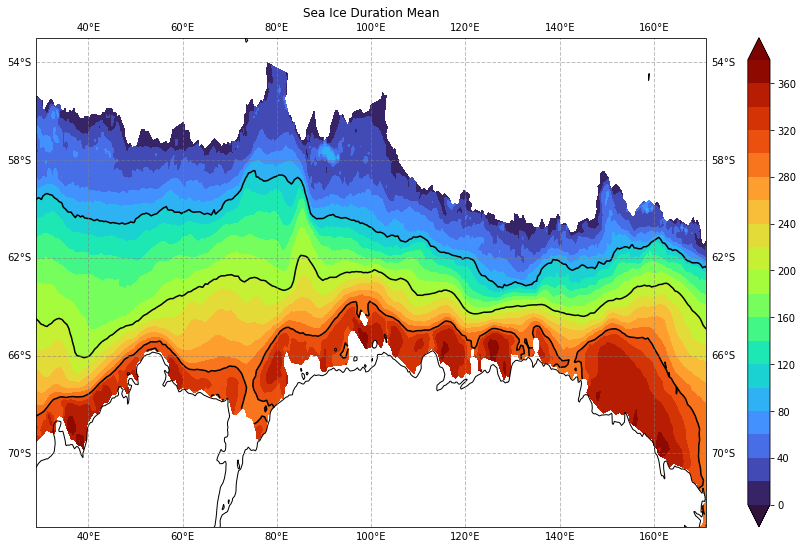

In [22]:
to_plot=cdr_duration.dur_climat_ds

plt.figure(figsize=(15,9))
ax=plt.subplot(
    projection=ccrs.PlateCarree(),
    xlim=(29,171),
    ylim=(-73,-53)
)

ax.set_aspect('auto')

plt.contourf(
    to_plot.x,
    to_plot.y,
    to_plot.ave,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
    levels=np.arange(0,381,20),
    cmap='turbo',
    extend='both'
)

plt.colorbar()

plt.contour(
    to_plot.x,
    to_plot.y,
    to_plot.ave,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
    levels=[100,200,300],
    colors='Black',
)

gl = ax.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
    xlocs=[40,60,80,100,120,140,160], ylocs=[-54,-58,-62,-66,-70]
)


ax.coastlines()
plt.title('Sea Ice Duration Mean')

# Anomalies

In [23]:
cdr_duration.calc_anoms()

In [24]:
YEAR=2021

/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


Text(0.5, 1.0, 'Sea Ice Advance - 2021')

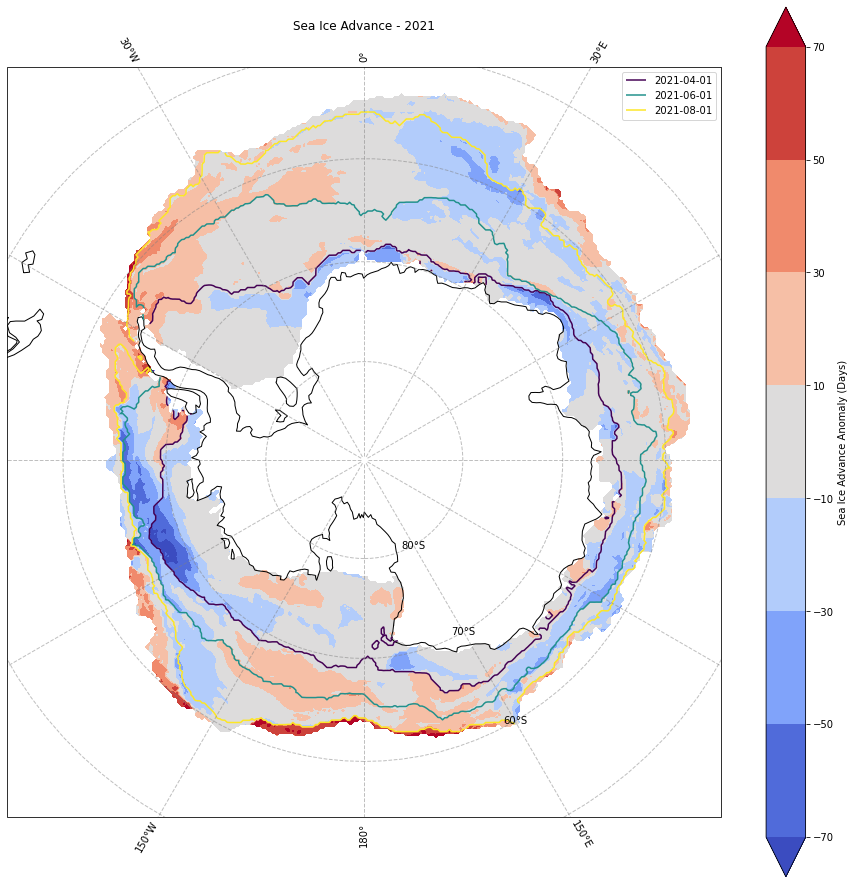

In [25]:
to_plot_da=cdr_duration.adv_anom_da.sel(year=YEAR)

plt.figure(figsize=(16,16))
ax=plt.subplot(projection=ccrs.SouthPolarStereo())

plt.contourf(
    to_plot_da.x,
    to_plot_da.y,
    to_plot_da,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
    cmap='coolwarm',
    levels=np.arange(-70,71,20),
    extend='both'
)
plt.colorbar(label='Sea Ice Advance Anomaly (Days)')

contour_date_ls=[
    np.datetime64(f'{YEAR}-{iMonth:02.0f}-01') for iMonth in [4,6,8] #july, august, sept, nov
]

cs=plt.contour(
    adv_day_ds.x,
    adv_day_ds.y,
    cdr_duration.adv_day_ds.index.sel(year=YEAR),
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
    levels=[(iCon-np.datetime64(f'{YEAR}-02-16')).astype(int) for iCon in contour_date_ls],
    linewidth=1.5
)

for i in np.arange(0,len(contour_date_ls)):
    cs.collections[i].set_label(s=np.datetime_as_string(contour_date_ls[i], 'D')) 

gl = ax.gridlines(
        draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
        xlocs=[-150,-120,-90,-60,-30,0,30,60,90,120,150,180], ylocs=[-50,-60,-70,-80]
)

plt.legend()
ax.coastlines()
plt.title('Sea Ice Advance - '+str(YEAR))


Text(0.5, 1.0, 'Sea Ice Retreat - 2021')

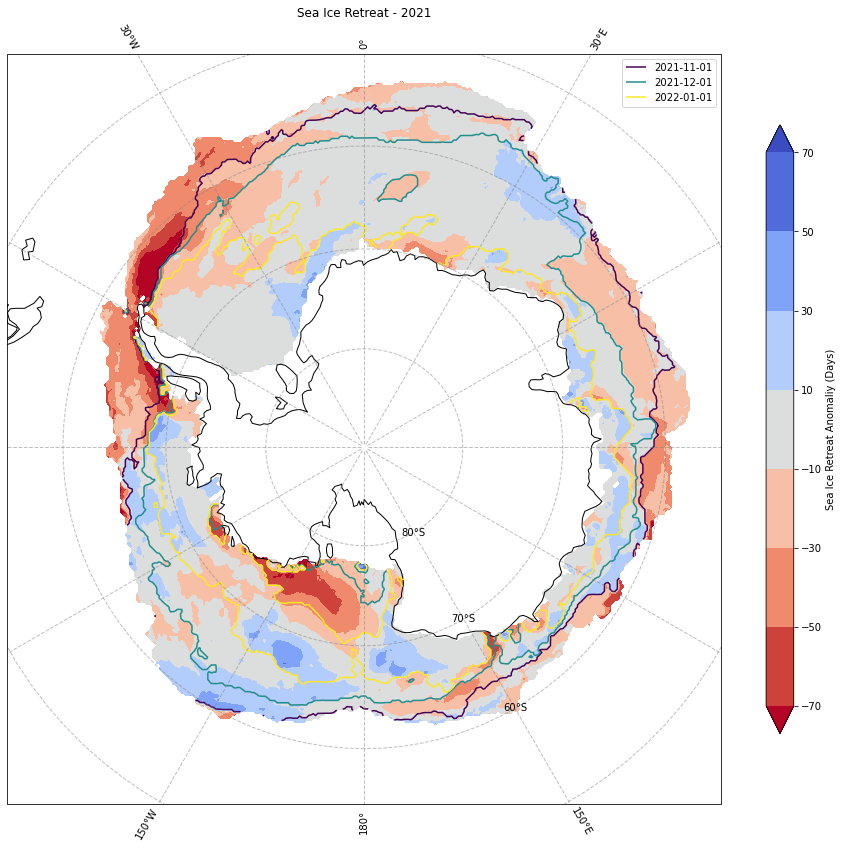

In [26]:
to_plot_da=cdr_duration.ret_anom_da.sel(year=YEAR)

plt.figure(figsize=(16,16))
ax=plt.subplot(projection=ccrs.SouthPolarStereo())

plt.contourf(
    to_plot_da.x,
    to_plot_da.y,
    to_plot_da,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
    cmap='coolwarm_r',
    levels=np.arange(-70,71,20),
    extend='both'
)

plt.colorbar(shrink=0.7, label='Sea Ice Retreat Anomaliy (Days)')


contour_date_ls=[
    *[np.datetime64(f'{YEAR}-{iMonth:02.0f}-01') for iMonth in [11,12]],
    np.datetime64(f'{YEAR+1}-01-01')
]

cs=plt.contour(
    cdr_duration.ret_day_ds.x,
    cdr_duration.ret_day_ds.y,
    cdr_duration.ret_day_ds.index.sel(year=YEAR),
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
    levels=[(iCon-np.datetime64(f'{YEAR}-02-16')).astype(int) for iCon in contour_date_ls],
    linewidth=1.5
)

for i in np.arange(0,len(contour_date_ls)):
    cs.collections[i].set_label(s=np.datetime_as_string(contour_date_ls[i], 'D')) 

gl = ax.gridlines(
        draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
        xlocs=[-150,-120,-90,-60,-30,0,30,60,90,120,150,180], ylocs=[-50,-60,-70,-80]
)

plt.legend()

ax.coastlines()
plt.title('Sea Ice Retreat - '+str(YEAR))

/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'Sea Ice Duration - 2021')

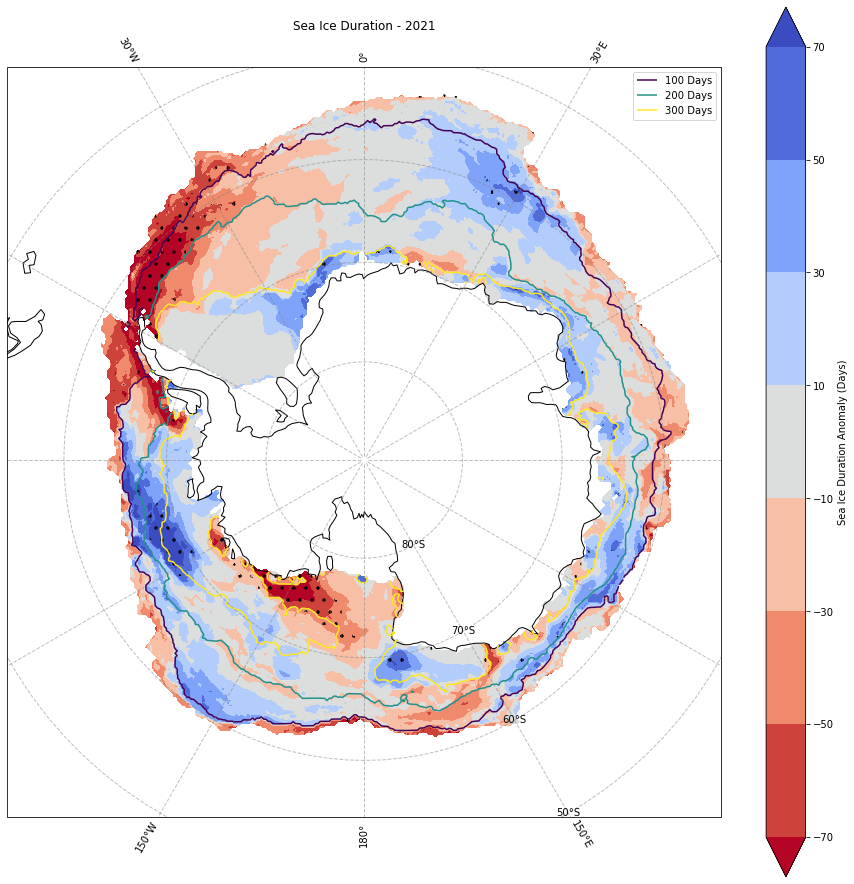

In [27]:
to_plot_da=cdr_duration.dur_anom_da.sel(year=YEAR)

plt.figure(figsize=(16,16))
ax=plt.subplot(projection=ccrs.SouthPolarStereo())

plt.contourf(
    to_plot_da.x,
    to_plot_da.y,
    to_plot_da,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
    cmap='coolwarm_r',
    levels=np.arange(-70,71,20),
    extend='both'
)


plt.colorbar(label='Sea Ice Duration Anomaly (Days)')

contour_days=[100,200,300]
cs=plt.contour(
    cdr_duration.duration_da.x,
    cdr_duration.duration_da.y,
    cdr_duration.duration_da.sel(year=YEAR),
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
    levels=contour_days,
    linewidth=1.5
)

for i in np.arange(0,len(contour_days)):
    cs.collections[i].set_label(s=f'{contour_days[i]} Days') 
    
plt.legend()

plot_stipling(
    to_plot_da,
    2*cdr_duration.dur_climat_ds.st_dev,
    ax)

gl = ax.gridlines(
        draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
        xlocs=[-150,-120,-90,-60,-30,0,30,60,90,120,150,180], ylocs=[-50,-60,-70,-80]
)

ax.coastlines()
plt.title('Sea Ice Duration - '+str(YEAR))

# Figures for tracker

In [ ]:
for i in cdr_duration.dur_anom_da.year.values:

    to_plot_da=cdr_duration.dur_anom_da.sel(year=i)

    plt.figure(figsize=(79,83), dpi=20, frameon=False, facecolor=None)
    ax=plt.subplot(projection=ccrs.SouthPolarStereo())

    cs1 = plt.contourf(
        to_plot_da.x,
        to_plot_da.y,
        to_plot_da.values,
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='coolwarm_r',
        #vmin=-70, vmax=70 ,
        levels=np.arange(-70,71,20),
        extend='both'
    )
    
    levels=[
        100,200,300
        #np.datetime64(f'{YEAR}-{iMonth:02.0f}-01') for iMonth in [4,6,8] #july, august, sept
    ]

    cs2 = plt.contour(
        duration_da.x,
        duration_da.y,
        duration_da.sel(year=YEAR),
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        #levels=[(iCon-np.datetime64(f'{YEAR}-02-16')).astype(int) for iCon in contour_date_ls],
        levels=levels,
        linewidths=15
    )

    plt.rcParams['hatch.linewidth'] = 3
    
    plot_stipling(
        to_plot_da,
        2*cdr_duration.dur_climat_ds.st_dev,
        ax
    )
    
    ax.axis('off')
    
    ax.set_extent([-3950000.0, 3950000.0,-3950000.0, 4350000.0],ccrs.SouthPolarStereo())
        
    plt.savefig(
        f'{_work_dir}data/tracker/duration_anoms/{i}.svg',
        bbox_inches="tight", transparent="True"
    )
   
    plt.close()


/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/jk

Legend 

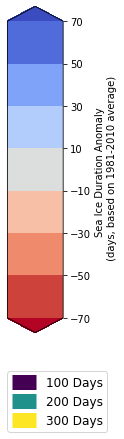

In [162]:
fig=plt.figure(figsize=(1,6))
cax=plt.subplot() 
plt.colorbar(
    mappable=cs1 ,
    cax=cax,
    label='Sea Ice Duration Anomaly \n (days, based on 1981-2010 average)',
)

handles, _ = cs2.legend_elements()

#cax = plt.subplot(1,2,2)
#cax.axis(False)
labels = ['100 Days', '200 Days', '300 Days'] 
cax.legend(handles,labels, bbox_to_anchor=(1.9, -0.1), prop={"size":12})

plt.savefig(f'{_work_dir}data/tracker/sea_ice_dur_anoms_legend.png',
               bbox_inches='tight', transparent="True")